# Differential expression and GO enrichment analysis

This tutorial demonstrates how to perform Differential Expression (DE) analysis and Gene Ontology (GO) enrichment analysis on the high-definition clustering results obtained from SpaHDmap. We use the results from [Analysis of multi-section ST data](./Multi-section.ipynb) tutorial as an illustrative example.

## 1. Import necessary libraries

First, we load the necessary R libraries, including `Seurat` and `clusterProfiler` for data analysis.

In [1]:
library(Seurat)
library(ggplot2)
library(clusterProfiler)
library(org.Hs.eg.db)

Warning message:
"package 'Seurat' was built under R version 4.4.3"
Loading required package: SeuratObject

Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.3"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t




clusterProfiler v4.12.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan,
X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal
enrichment tool for interpreting omics data. The Innovation. 2021,
2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following object is masked from 'package:SeuratObject':

    intersect


The following objects are mas

## 2. Load the data and pre-process

We will load the data from multiple samples, normalize it, and assign cluster labels based on the provided metadata. The `threshold` variable is used to filter out spots with low confidence in their clustering.

Note that the spot's clustering metadata is processed by average the pixel cluster labels in this spot.

### Load and process expression data

In [2]:
# Set the threshold for label assignment
threshold <- 0.7

In [3]:
# Load data from multiple samples and perform normalization
data_list <- list()
for (sample in c("Palbocilib_A","Palbocilib_B","Control_C","Control_D")){
  data <- Load10X_Spatial(data.dir = paste0("data/",sample), filename = "raw_feature_bc_matrix.h5")
  data <- NormalizeData(data)

  # Load clustering metadata
  clustering <- read.csv(paste0("data/", sample, "/", sample, "_meta.csv"), row.names = 1)
  label <- apply(clustering,1,function(x){which.max(x)[1]})
  label[apply(clustering,1,max)<=threshold] <- NA
  data <- AddMetaData(data,label,"cluster")
  data_list[[sample]] <- data
}

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Normalizing layer: counts

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Normalizing layer: counts

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Normalizing layer: counts

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"
Normalizing layer: counts



In [14]:
# Merge the data from all samples into a single Seurat object
data <- scCustomize::Merge_Seurat_List(
  data_list,
  add.cell.ids = names(data_list),
  merge.data = TRUE,
  project = "SeuratProject"
)

data <- JoinLayers(data)

Warning message:
"Key 'slice1_' taken, using 'slice12_' instead"
Warning message:
"Key 'slice1_' taken, using 'slice12_' instead"
Warning message:
"Key 'slice1_' taken, using 'slice12_' instead"


### Refine cluster labels

We map the numeric cluster labels to more descriptive names (e.g., T1, T2) and handle spots that were not confidently clustered by labeling them as 'Normal' for the DEG analysis.

In [15]:
data@meta.data$cluster <- plyr::mapvalues(data@meta.data$cluster,
                                          c("3","4","1","2","6","10","13","15"),
                                          c("T1","T2","T3","T4","T5","T6","T7","T8"))
data@meta.data$cluster[!stringr::str_detect(data@meta.data$cluster,"T")] <- NA
data@meta.data$spot_cluster_forDEG <- data@meta.data$cluster
data@meta.data$spot_cluster_forDEG[is.na(data@meta.data$spot_cluster_forDEG)] <- "Normal"

## 3. Perform differential expression analysis and GO enrichment analysis

### Differential expression analysis

Using `FindMarkers` from Seurat, we identify genes that are differentially expressed between each tumor cluster and the 'Normal' spots.

In [16]:
DEG_list <- list()
cluster_list <- paste0("T",1:8)
data <- data[stringr::str_detect(rownames(data), "hg38-"),]
rownames(data) <- stringr::str_remove(rownames(data), "hg38-")

for (cluster in cluster_list){
  DEG_list[[cluster]] <- FindMarkers(data,ident.1 = cluster,ident.2 = "Normal",
                                     group.by = "spot_cluster_forDEG", logfc.threshold=0,
                                     only.pos = T)
}

Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Seurat objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating Centroids objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating FOV objects"
Warning message:
"Not validating Seurat objects"


### GO enrichment analysis

Next, we use the `enricher` function in the `clusterProfiler` package to perform GO enrichment analysis on the differentially expressed genes.

In [17]:
geneset <- readRDS("data/GenesetForGO.rds")

DEG_tidy <- list()
for (cluster in cluster_list){
  DEG_tidy[[cluster]] <- rownames(DEG_list[[cluster]])
}

# Perform enrichment analysis using the `enricher` function from `clusterProfiler`
ck <- compareCluster(geneCluster = DEG_tidy, fun = enricher, TERM2GENE = geneset, pvalueCutoff = 0.1)

### Visualize Enrichment Results

Finally, we create a dot plot to visualize the results of the enrichment analysis, focusing on specific pathways of interest.

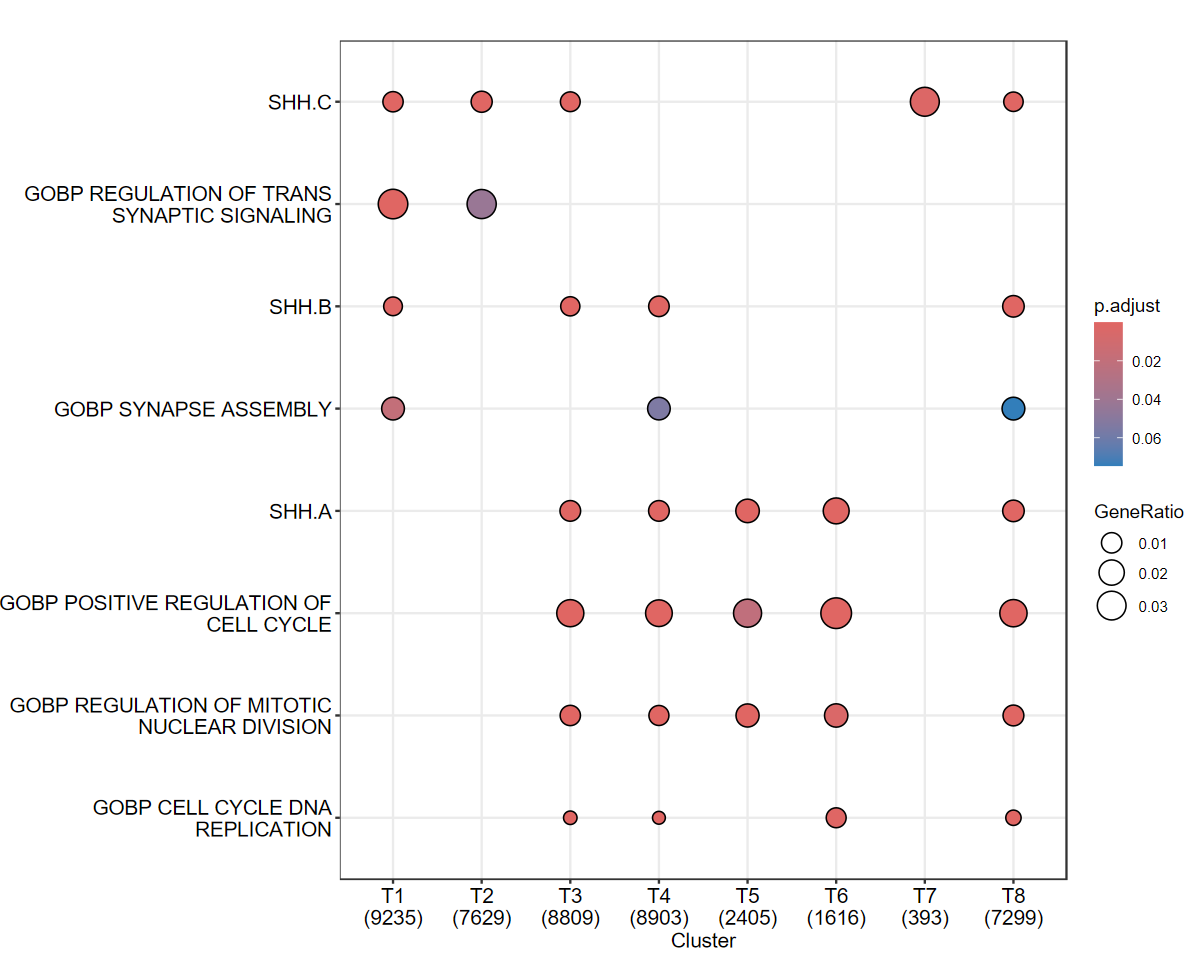

In [18]:
ck_copy <- ck
ck_copy@compareClusterResult <- ck_copy@compareClusterResult[ck_copy@compareClusterResult$ID %in% c("SHH.A","SHH.B","SHH.C","NEURON_DIFFERENTIATION","GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE","GOBP_REGULATION_OF_MITOTIC_NUCLEAR_DIVISION","GOBP_REGULATION_OF_TRANS_SYNAPTIC_SIGNALING","GOBP_SYNAPSE_ASSEMBLY","GOBP_CELL_CYCLE_DNA_REPLICATION"),]

options(repr.plot.width = 10, repr.plot.height = 8)
dotplot(ck_copy,showCategory = 10)